In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
#%matplotlib inline

In [2]:
def getAcc( pos, mass, G, softening ):
    """
    Calculate the acceleration on each particle due to Newton's Law 
    pos  is an N x 3 matrix of positions
    mass is an N x 1 vector of masses
    G is Newton's Gravitational constant
    softening is the softening length
    a is N x 3 matrix of accelerations
    """
    # positions r = [x,y,z] for all particles
    x = pos[:,0:1]
    y = pos[:,1:2]
    z = pos[:,2:3]


    
    # calculate r (distance between particles)
    # check if r<cross section
    # if r<cross section then collision
    # collision function returns how much acceleration changes?

        
    # matrix that stores all pairwise particle separations: r_j - r_i
    dx = x.T - x
    dy = y.T - y
    dz = z.T - z

    # matrix that stores 1/r^3 for all particle pairwise particle separations 
    inv_r3 = (dx**2 + dy**2 + dz**2 + softening**2)
    inv_r3[inv_r3>0] = inv_r3[inv_r3>0]**(-1.5)

    ax = G * (dx * inv_r3) @ mass # + collision
    ay = G * (dy * inv_r3) @ mass # + collision
    az = G * (dz * inv_r3) @ mass # + collision

    # pack together the acceleration components
    a = np.hstack((ax,ay,az))

    return a

In [27]:
def collision(pos, vel, radius=0):
    N = pos.shape[0];
    collided=[]
    final_vel=[]
    for i in range(N):
        for j in range(1,N):
            if i!=j:
                dx = pos[j,0] - pos[i,0];
                dy = pos[j,1] - pos[i,1];
                dz = pos[j,2] - pos[i,2];
                if (dx**2 + dy**2 + dz**2) <= radius**2:
                    #return i,j
                    collided.append(i)
                    collided.append(j)
                    veli, velj = finalVelocities(pos[i], pos[j], vel[i], vel[j])
                    final_vel.append(veli)
                    final_vel.append(velj)
        #else:
            #print('NO COLLISION')
                
    #print(len(collided), len(final_vel))
    return collided, final_vel
                
    

In [4]:
def normal(pos1, pos2):
    pos_rel = np.array([pos1[0]-pos2[0], pos1[1]-pos2[1], pos1[2]-pos2[2]])
    pos_rel_mag = np.sqrt(pos_rel[0]**2+pos_rel[1]**2+pos_rel[2]**2)
    return pos_rel/pos_rel_mag

In [5]:
def v_rel(vel1, vel2):
    return np.array([vel1[0]-vel2[0], vel1[1]-vel2[1], vel1[2]-vel2[2]])

In [6]:
def v_norm(vel_rel, norm):
    return np.dot(vel_rel, norm)*norm

In [30]:
def finalVelocities(pos1, pos2, vel1, vel2):
    vel_norm=v_norm(v_rel(vel1, vel2), normal(pos1, pos2))
    return vel1-vel_norm, vel2+vel_norm

In [8]:
def getEnergy( pos, vel, mass, G ):
    """
    Get kinetic energy (KE) and potential energy (PE) of simulation
    pos is N x 3 matrix of positions
    vel is N x 3 matrix of velocities
    mass is an N x 1 vector of masses
    G is Newton's Gravitational constant
    KE is the kinetic energy of the system
    PE is the potential energy of the system
    """
    # Kinetic Energy:
    KE = 0.5 * np.sum(np.sum( mass * vel**2 ))


    # Potential Energy:

    # positions r = [x,y,z] for all particles
    x = pos[:,0:1]
    y = pos[:,1:2]
    z = pos[:,2:3]

    # matrix that stores all pairwise particle separations: r_j - r_i
    dx = x.T - x
    dy = y.T - y
    dz = z.T - z

    # matrix that stores 1/r for all particle pairwise particle separations 
    inv_r = np.sqrt(dx**2 + dy**2 + dz**2)
    inv_r[inv_r>0] = 1.0/inv_r[inv_r>0]

    # sum over upper triangle, to count each interaction only once
    PE = G * np.sum(np.sum(np.triu(-(mass*mass.T)*inv_r,1)))

    return KE, PE;

In [97]:
def main():
    """ N-body simulation """
    # Simulation parameters
    N         = 256    # Number of particles
    t         = 0      # current time of the simulation
    tEnd      = 5.0   # time at which simulation ends
    dt        = 0.01   # timestep
    softening = 0.1    # softening length
    G         = 1.0    # Newton's Gravitational Constant
    radius    = 0.1
    plotRealTime = False # switch on for plotting as the simulation goes along

    # Generate Initial Conditions
    np.random.seed(17)            # set the random number generator seed

    mass = 20.0*np.ones((N,1))/N  # total mass of particles is 20
    pos  = np.random.randn(N,3)   # randomly selected positions and velocities
    vel  = np.random.randn(N,3)

    # Convert to Center-of-Mass frame
    vel -= np.mean(mass * vel,0) / np.mean(mass)

    # calculate initial gravitational accelerations
    acc = getAcc( pos, mass, G, softening )

    # calculate initial energy of system
    KE, PE  = getEnergy( pos, vel, mass, G )

    # number of timesteps
    Nt = int(np.ceil(tEnd/dt))

    # save energies, particle orbits for plotting trails
    pos_save = np.zeros((N,3,Nt+1))
    pos_save[:,:,0] = pos
    KE_save = np.zeros(Nt+1)
    KE_save[0] = KE
    PE_save = np.zeros(Nt+1)
    PE_save[0] = PE
    t_all = np.arange(Nt+1)*dt
    collisions = 0 
    initial_cluster, final_cluster= 0,0
    for i in range(N):
        if pos[i,0]<2 and pos[i,1]<2 and pos[i,2]<2 and pos[i,0] > -2 and pos[i,1] > -2 and pos[i,2] > -2:
            initial_cluster += 1

    # prep figure
    fig = plt.figure(figsize=(4,
                              5), dpi=80)
    grid = plt.GridSpec(3, 1, wspace=0.0, hspace=0.3)
    ax1 = fig.add_subplot(grid[0:2,0], projection='3d')
    ax2 = fig.add_subplot(grid[2,0])

    # Simulation Main Loop
    for i in range(Nt):
        # (1/2) kick
        vel += acc * dt/2.0
        # drift
        pos += vel * dt
        # checks for collisions
        #m,n=collision(pos, radius)
        collided, final_vel=collision(pos, vel, radius)
        collisions+= len(collided)/2.0
        for index in range(len(collided)):
            vel[collided[index]] = final_vel[index]
            pos[collided[index]] += vel[collided[index]] * dt
        
        # update particles that had collisions
        # call finalVelocity on each pair and update velocity to that
        
        
        # update accelerations
        acc = getAcc( pos, mass, G, softening ) # plus change in acc due to collision
        # (1/2) kick
        vel += acc * dt/2.0
        # update time
        t += dt
        # get energy of system
        KE, PE  = getEnergy( pos, vel, mass, G )
        # save energies, positions for plotting trail
        pos_save[:,:,i+1] = pos
        KE_save[i+1] = KE
        PE_save[i+1] = PE

        # plot in real time
        if plotRealTime or (i == Nt-1):
#             plt.sca(ax1)
            ax1.cla()
            xx = pos_save[:,0,max(i-20,0):i+1]
            yy = pos_save[:,1,max(i-20,0):i+1]
            zz = pos_save[:,2,max(i-20,0):i+1]
            ax1.scatter(xx,yy,zz, s=1,color=[.7,.7,1], alpha=0.2)
            ax1.scatter(pos[:,0],pos[:,1],pos[:,2],s=15,color='blue')
            
            #if m and n:
                #print('collision!')
                #ax1.scatter(pos[m,0],pos[m,1],s=10,color='pink')
                #ax1.scatter(pos[n,0],pos[n,1],s=10,color='pink')
            if collided:
                unique=set(collided)
                for idx in unique:
                    ax1.scatter(pos[idx,0],pos[idx,1],pos[idx,2],s=15,color='pink')
                    xpink = pos_save[idx,0,max(i-20,0):i+1]
                    ypink = pos_save[idx,1,max(i-20,0):i+1]
                    zpink = pos_save[idx,2,max(i-20,0):i+1]
                    ax1.scatter(xpink,ypink,zpink, s=1,color='pink', alpha=0.8)
            
            ax1.set(xlim=(-2, 2), ylim=(-2, 2), zlim=(-2,2))
            #ax1.set_aspect('equal', 'box')
            ax1.set_xticks([-2,-1,0,1,2])
            ax1.set_yticks([-2,-1,0,1,2])
            ax1.set_zticks([-2,-1,0,1,2])

#             plt.sca(ax2)
            ax2.cla()
            ax2.scatter(t_all,KE_save,color='red',s=1,label='KE' if i == Nt-1 else "")
            ax2.scatter(t_all,PE_save,color='blue',s=1,label='PE' if i == Nt-1 else "")
            ax2.scatter(t_all,KE_save+PE_save,color='green',s=1,label='Etot' if i == Nt-1 else "")
            #ax2.set(xlim=(0, tEnd), ylim=(-1000, 1000))
            ax2.set_aspect('auto')#(0.007)

            plt.pause(0.001)
            display(fig)
            if i < Nt-1:
                clear_output(wait=True)
#             fig.canvas.draw()
        
    # add labels/legend
    #plt.sca(ax2)
    for i in range(N):
        if pos[i,0]<2 and pos[i,1]<2 and pos[i,2]<2 and pos[i,0] > -2 and pos[i,1] > -2 and pos[i,2] > -2:
            final_cluster += 1
        
    ax2.set_xlabel('time')
    ax2.set_ylabel('energy')
    ax2.legend(loc='upper right')
    # Save figure
    print("Number of collisions: ", collisions)
    print("Cluster stats: intial, final", initial_cluster, final_cluster)
    plt.savefig('nbody.png',dpi=240)
    plt.show()

    return 0

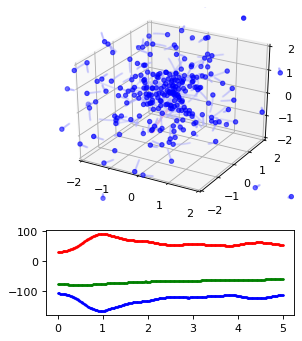

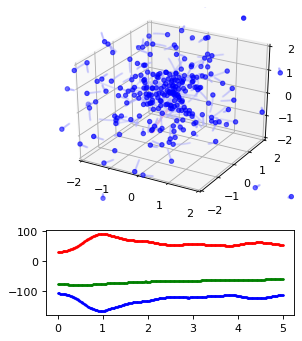

Number of collisions:  3646.0
Cluster stats: intial, final 222 193


<Figure size 640x480 with 0 Axes>

CPU times: user 6min 19s, sys: 10.5 s, total: 6min 30s
Wall time: 1min 51s


In [98]:
%%time
if __name__== "__main__":
  main()

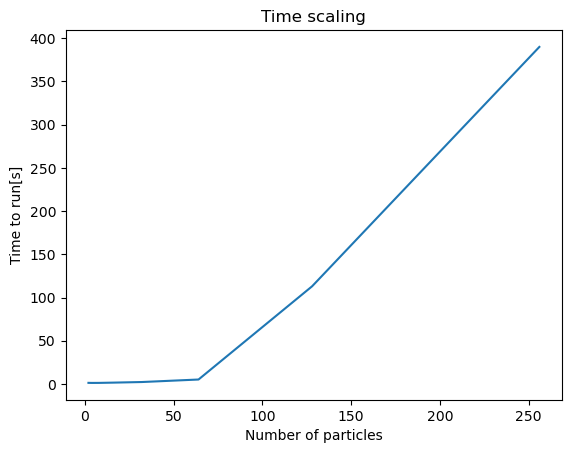

In [102]:
#Scalability 
particles = [2, 4, 8, 16, 32, 64, 128, 256]
time = [1.22, 1.14, 1.18, 1.48, 2.17, 5.08, 113, 390]

plt.title('Time scaling')
plt.xlabel('Number of particles')
plt.ylabel('Time to run[s]')
plt.plot(particles, time)
plt.show()

In [111]:
0.0635984469171379**2 +  (-0.020252722825680566)**2 <= 0

False